### **Load Data**

In [1]:
# Libraries
import pandas as pd

# Function to load data from csv.
def load_data(df):
    return pd.read_csv(file_path)

file_path = '../data/flight_df.csv'

# Load the dataset
df = load_data(file_path)

selected_columns = [
'Inflight wifi service',
'Age',
'Flight Distance',
'Class',
'Online boarding',
'Checkin service',
'Loyal Customer',
'Seat comfort',
'Leg room service',
'Business Travel',
'satisfied']

# Filter dataframe to use only selected columns
df = df[selected_columns]
df.head()

,Inflight wifi service,Age,Flight Distance,Class,Online boarding,Checkin service,Loyal Customer,Seat comfort,Leg room service,Business Travel,satisfied
0,2,26,2062,3,2,3,1,2,3,1,0
1,5,52,680,3,4,4,1,4,4,1,1
2,3,28,188,1,3,4,1,3,3,0,0
3,3,54,453,3,4,4,1,4,3,1,0
4,4,40,775,1,4,3,1,4,1,1,0


### **Model Validation**

In [2]:
from sklearn.model_selection import train_test_split

# Define the traget and features
y = df['satisfied']
X = df.drop(columns='satisfied')

In [3]:
# Save the new dataframe for app
import os

data_path = '../data/app_flight_df.csv'

try:
    # Save the features dataframe for app
    X.to_csv(data_path, index=False)

    # Confirm if successful
    if os.path.exists(data_path):
        print(f'Dataframe saved successfully to: {data_path}')
    else:
        print(f'Failed to save dataframe: {data_path}')

except Exception as error:
    print(f'Error in saving dataframe to {data_path}: {error}')

Dataframe saved successfully to: ../data/app_flight_df.csv


In [4]:
# Split the data into train and test 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check for class imbalance
y.value_counts(normalize=True)

satisfied
0    0.56695
1    0.43305
Name: proportion, dtype: float64

### **Preprocessing**

In [5]:
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline

# Preprocessing pipeline
def create_preprocessing_pipeline():

    # Select numeric and categorical columns
    num_cols = make_column_selector(dtype_include='number')
    cat_cols = make_column_selector(dtype_include='object')

    # Instantiate the transformers
    scaler = StandardScaler()
    encoder = OneHotEncoder()
    knn_imputer = KNNImputer(n_neighbors=2, weights='uniform')

    # Create pipeline
    num_pipe = Pipeline([
        ('scaler', scaler),
        ('imputer', knn_imputer)
    ])

    cat_pipe = Pipeline([
        ('encoder', encoder)
    ])

    preprocessor = ColumnTransformer([
        ('numeric', num_pipe, num_cols),
        ('categorical', cat_pipe, cat_cols)
    ], remainder='drop')

    return preprocessor

# Create preprocessor object
preprocessor = create_preprocessing_pipeline()

In [6]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Create sampler pipeline
def sampler_pipeline(sampler):
    return ImbPipeline([
        ('sampler', sampler)
    ])

# Preprocess and rebalance the data
def preprocess_and_rebalance_data(preprocessor, X_train, X_test, y_train):

    # Transform training data to the fitted transformer
    X_train_transformed = preprocessor.fit_transform(X_train)
    X_test_transformed = preprocessor.transform(X_test)

    # Create sampling pipeline
    sampler = sampler_pipeline(SMOTE(random_state=42))

    # Rebalance the data
    X_train_balanced, y_train_balanced = sampler.fit_resample(X_train_transformed, y_train)

    return X_train_balanced, X_test_transformed, y_train_balanced

# Preprocess and rebalance the data
X_train_balanced, X_test_transformed, y_train_balanced = preprocess_and_rebalance_data(preprocessor, X_train, X_test, y_train)

In [7]:
# Convert preprocessed data back to a dataframe
X_train_balanced_df = pd.DataFrame(X_train_balanced)
X_test_transformed_df = pd.DataFrame(X_test_transformed)

### **Machine Learning**

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# Function to evaluate model
def evaluate_model(model, X_train, y_train, X_test, y_test):

    # Create predictions on the training set
    train_preds = np.rint(model.predict(X_train)) # rint round to the nearest integer
    test_preds = np.rint(model.predict(X_test))

    # Classification report
    train_report = classification_report(y_train, train_preds)
    test_report = classification_report(y_test, test_preds)

    # Confusion matrix
    cm_train = confusion_matrix(y_train, train_preds)
    cm_test = confusion_matrix(y_test, test_preds)

    # Format figures in dark mode
    plt.style.use('dark_background')

    # Plot confusion matrix side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # First axis
    axes[0].text(0.01, 0.05, str(train_report), font_properties='monospace')
    axes[0].axis('off')

    # Seconds axis
    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
    disp_train.plot(ax=axes[1], cmap='YlGn_r')
    axes[1].set_title('Confusion Matrix - Training Set')

    # Plot confusion matrix side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # First axis
    axes[0].text(0.01, 0.05, str(test_report), font_properties='monospace')
    axes[0].axis('off')

    # Seconds axis
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
    disp_train.plot(ax=axes[1], cmap='Purples')
    axes[1].set_title('Confusion Matrix - Testing Set')

    return train_report, test_report

    plt.show()

In [9]:
from matplotlib import colormaps
list(colormaps)

['magma',
 'inferno',
 'plasma',
 'viridis',
 'cividis',
 'twilight',
 'twilight_shifted',
 'turbo',
 'Blues',
 'BrBG',
 'BuGn',
 'BuPu',
 'CMRmap',
 'GnBu',
 'Greens',
 'Greys',
 'OrRd',
 'Oranges',
 'PRGn',
 'PiYG',
 'PuBu',
 'PuBuGn',
 'PuOr',
 'PuRd',
 'Purples',
 'RdBu',
 'RdGy',
 'RdPu',
 'RdYlBu',
 'RdYlGn',
 'Reds',
 'Spectral',
 'Wistia',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 'afmhot',
 'autumn',
 'binary',
 'bone',
 'brg',
 'bwr',
 'cool',
 'coolwarm',
 'copper',
 'cubehelix',
 'flag',
 'gist_earth',
 'gist_gray',
 'gist_heat',
 'gist_ncar',
 'gist_rainbow',
 'gist_stern',
 'gist_yarg',
 'gnuplot',
 'gnuplot2',
 'gray',
 'hot',
 'hsv',
 'jet',
 'nipy_spectral',
 'ocean',
 'pink',
 'prism',
 'rainbow',
 'seismic',
 'spring',
 'summer',
 'terrain',
 'winter',
 'Accent',
 'Dark2',
 'Paired',
 'Pastel1',
 'Pastel2',
 'Set1',
 'Set2',
 'Set3',
 'tab10',
 'tab20',
 'tab20b',
 'tab20c',
 'grey',
 'gist_grey',
 'gist_yerg',
 'Grays',
 'magma_r',
 'inferno_r',
 'plasma_r',
 'viri

In [10]:
from sklearn.pipeline import Pipeline

# ML pipeline
def train_predict_model(X_train, y_train, X_test, preprocessor, model):

    # Combine pipeline and model
    model_pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Fit pipeline on training data
    model_pipe.fit(X_train, y_train)

    # Save predictions
    train_preds = model_pipe.predict(X_train)
    test_preds = model_pipe.predict(X_test)

    return train_preds, test_preds

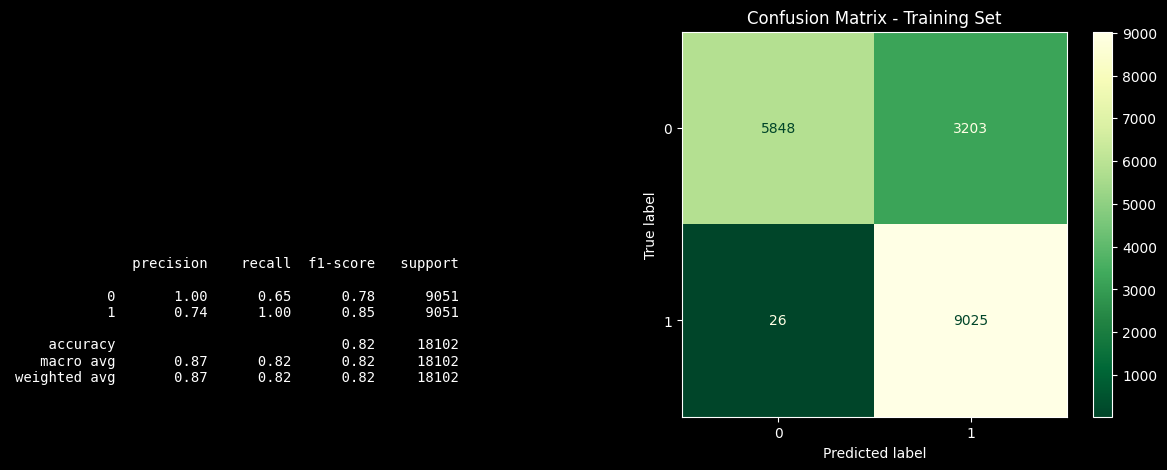

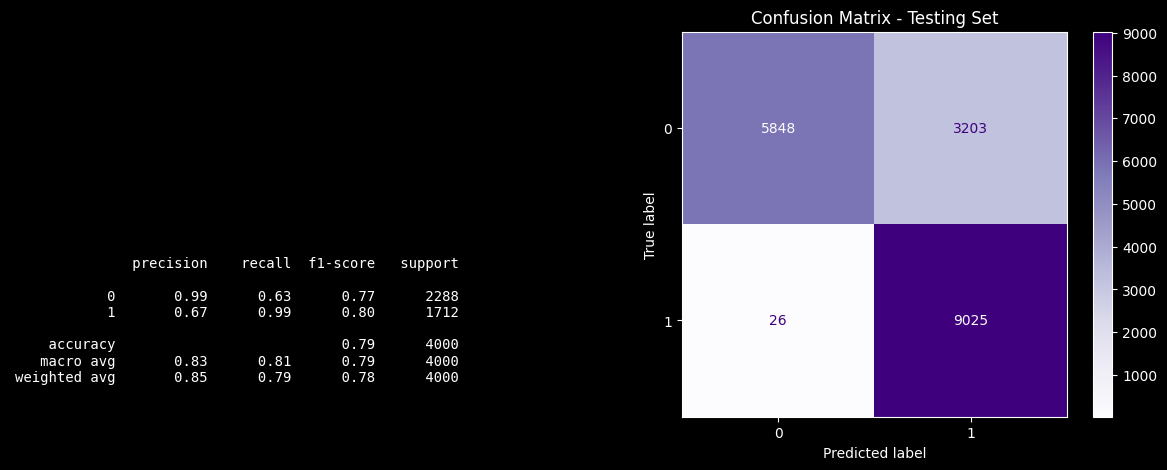

In [11]:
import lightgbm as lgb

# Instantiate the model
lgb_model = lgb.LGBMClassifier(verbose=-1, random_state=42)

# Create and save predictions
train_preds, test_preds = train_predict_model(X_train_balanced_df, y_train_balanced, X_test_transformed_df, preprocessor, lgb_model)

# Return train and test reports
train_report, test_reports = evaluate_model(lgb_model, X_train_balanced_df, y_train_balanced, X_test_transformed_df, y_test)

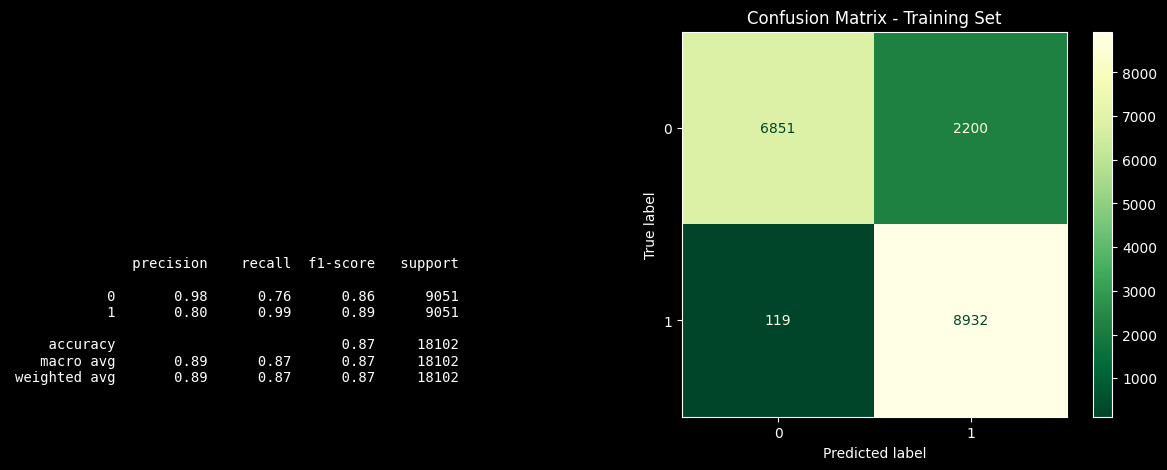

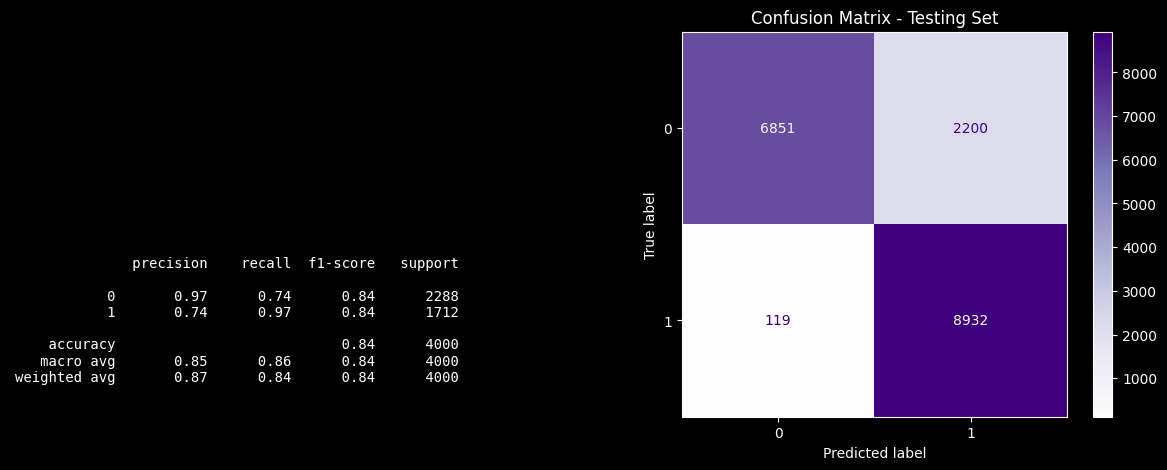

In [12]:
from sklearn.tree import DecisionTreeClassifier

# Instantiate the model
dec_model = DecisionTreeClassifier()

# Create and save predictions
train_preds, test_preds = train_predict_model(X_train_balanced_df, y_train_balanced, X_test_transformed_df, preprocessor, dec_model)

# Return train and test reports
train_report, test_reports = evaluate_model(dec_model, X_train_balanced_df, y_train_balanced, X_test_transformed_df, y_test)

### **Model Evaluation**

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Train model
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)

    return model

# Get feature importance
def get_feature_importance(model):

    feature_names = X_train.columns
    importance = model.feature_importances_

    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values(by='importance', ascending=False)

    return feature_importance

# PLot feature importance
def plot_feature_importance(feature_importance, title):

    plt.figure(figsize=(10, 6))

    # Barplot
    sns.barplot(
        data=feature_importance,
        x='importance',
        y='feature',
        palette='Spectral_r',
        hue='feature'
    )

    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

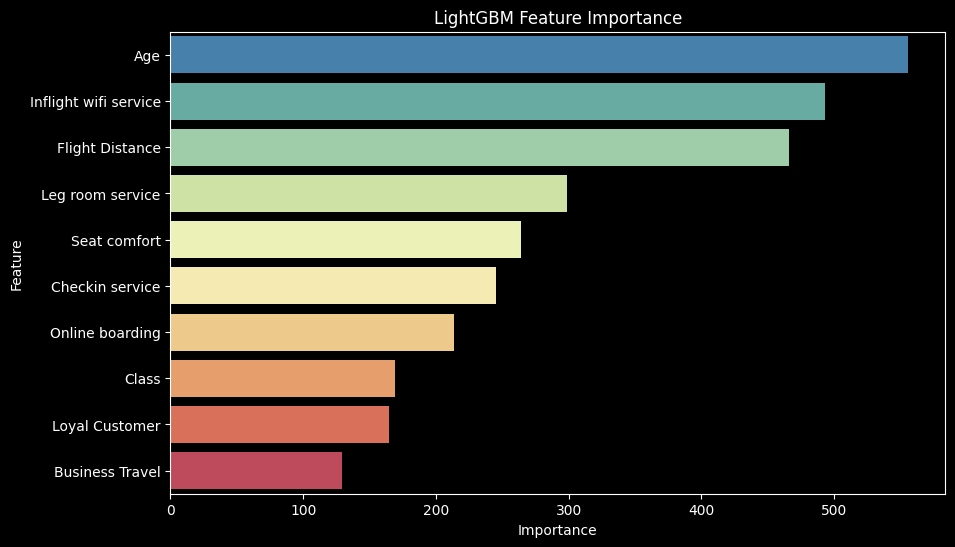

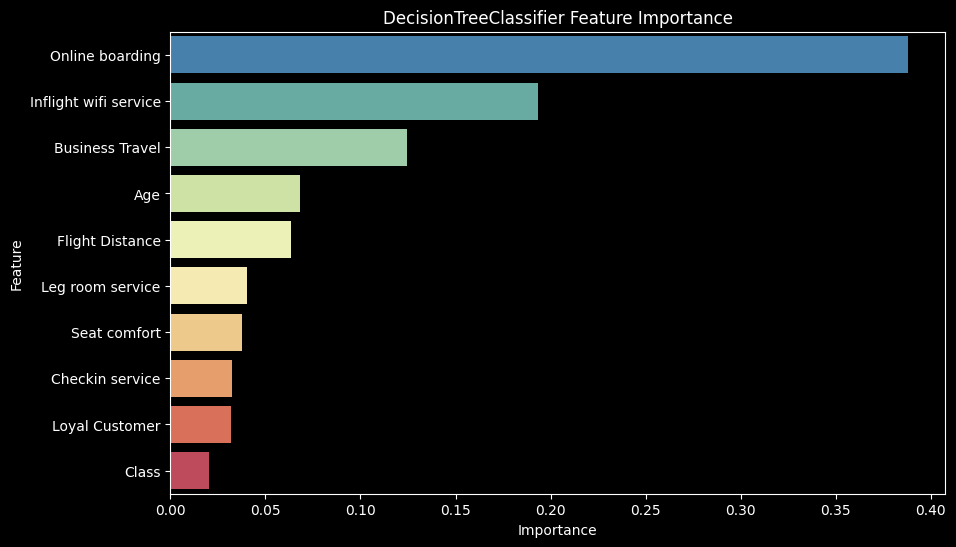

In [14]:
# Train LGBMClassifier
trained_lgb_model = train_model(lgb_model, X_train_balanced, y_train_balanced)

# Get and plot feature importance of LGBClassifier
lgbm_feature_importance = get_feature_importance(trained_lgb_model)
plot_feature_importance(lgbm_feature_importance, title='LightGBM Feature Importance')

# Train DecisionTreeClassifier
trained_dec_model = train_model(dec_model, X_train_balanced, y_train_balanced)

# Get and plot feature importance of DecisionTreeClassifier
dec_feature_importance = get_feature_importance(trained_dec_model)
plot_feature_importance(dec_feature_importance, title='DecisionTreeClassifier Feature Importance')

### **Save Models**

In [18]:
import joblib
import os

# Save model
# def save_model(model, model_path):

#    try:
#        # Save the model
#        joblib.dump(model, model_path)

        # Confirm save if successful
#        if os.path.exists(model_path):
#            print(f'Model saved successfully to: {model_path}')
#        else:
#            print(f'Failed to save model: {model_path}')
    
#    except Exception as error:
#        print(f'Error saving model to: {model_path}: {error}')

import joblib
import os

# Save model
def save_model(model, model_path):
    try:
        # Check if model directory exists
        dir_name = os.path.dirname(model_path)
        if not os.path.exists(dir_name):
            os.makedirs(dir_name)
        
        # Save the model
        joblib.dump(model, model_path)

        # Confirm save if successful
        if os.path.exists(model_path):
            print(f'Model saved successfully to: {model_path}')
        else:
            print(f'Failed to save model: {model_path}')        

    except Exception as error:
        print(f'Error saving mode to {model_path}: {error}')

In [19]:
# Save the LGBMClassifier
model_path = '../models/lgb.model.joblib'
save_model(lgb_model, model_path)

Model saved successfully to: ../models/lgb.model.joblib


In [20]:
# Save the DecisionTreeClassifier
model_path = '../models/dec.model.joblib'
save_model(lgb_model, model_path)

Model saved successfully to: ../models/dec.model.joblib
